In [56]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [57]:
%matplotlib inline

In [58]:
X_train, y_train, X_test, y_test = joblib.load('data_FAA/data.pkl')

In [59]:
X_train.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'CabinNumber', 'Total', 'cat_Total', 'cat_Age', 'boo_CryoSleep',
       'boo_VIP', 'cat_HomePlanet', 'cat_Destination', 'cat_Group',
       'cat_Group_id', 'cat_FirstName', 'cat_Surname', 'cat_Deck',
       'cat_CabinSide'],
      dtype='object')

In [76]:
PARAMETERS = {'booster' : ['gbtree', "dart"],
              'gamma': [1, 5,],
              'eta': [0.05],
              'learning_rate': [0.05,0.1],
              "subsample": [1], 
              'max_depth': [8, 10],
              'n_estimators': [600, 1000],
              "colsample_bytree": [0.5,0.88],
              "scale_pos_weight": [1,],
              'reg_alpha': [0,1],
              'reg_lambda': [2,],}

# HalvingGridSearchCV
grid_search_xgb = HalvingGridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                           eval_metric="auc"),param_grid=PARAMETERS,verbose = 1,
                                                           cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                           resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

xgbr_best = grid_search_xgb.best_estimator_
print("Extreme Gradient Boosting")
print('xgbr_best Best Score',grid_search_xgb.best_score_)
print('xgbr_best Best Parmas',grid_search_xgb.best_params_)
print('xgbr_best Accuracy',cross_val_score(xgbr_best,X_train.values, y_train.values.ravel(), cv=10).mean())

n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 40
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 128
n_resources: 40
Fitting 10 folds for each of 128 candidates, totalling 1280 fits
----------
iter: 1
n_candidates: 43
n_resources: 120
Fitting 10 folds for each of 43 candidates, totalling 430 fits
----------
iter: 2
n_candidates: 15
n_resources: 360
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Extreme Gradient Boosting
xgbr_best Best Score 0.7669841269841269
xgbr_best Best Parmas {'booster': 'dart', 'colsample_bytree': 0.88, 'eta': 0.05, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 2, 'scale_pos_weight': 1, 'subsample': 1}
xgbr_best Accuracy 0.7941786283891548


In [61]:
from sklearn.model_selection import cross_val_score
model = xgb.XGBClassifier()

In [62]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=1)
evalset = [(X_train2, y_train2), (X_val,y_val)]
model.fit(X_train2, y_train2, eval_metric='logloss', eval_set=evalset)

[0]	validation_0-logloss:0.54796	validation_1-logloss:0.59000
[1]	validation_0-logloss:0.46368	validation_1-logloss:0.53781
[2]	validation_0-logloss:0.39565	validation_1-logloss:0.50550
[3]	validation_0-logloss:0.34786	validation_1-logloss:0.48436
[4]	validation_0-logloss:0.31283	validation_1-logloss:0.47820
[5]	validation_0-logloss:0.27818	validation_1-logloss:0.47300
[6]	validation_0-logloss:0.25681	validation_1-logloss:0.46812
[7]	validation_0-logloss:0.23792	validation_1-logloss:0.45898
[8]	validation_0-logloss:0.22311	validation_1-logloss:0.45786
[9]	validation_0-logloss:0.20792	validation_1-logloss:0.44531
[10]	validation_0-logloss:0.19705	validation_1-logloss:0.44665
[11]	validation_0-logloss:0.18676	validation_1-logloss:0.44953
[12]	validation_0-logloss:0.18075	validation_1-logloss:0.44808
[13]	validation_0-logloss:0.16838	validation_1-logloss:0.44677
[14]	validation_0-logloss:0.16150	validation_1-logloss:0.45092
[15]	validation_0-logloss:0.15168	validation_1-logloss:0.45378
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [63]:
from sklearn.metrics import accuracy_score
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.765


In [64]:
# retrieve performance metrics
results = model.evals_result()

In [65]:
X_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,Total,cat_Total,cat_Age,boo_CryoSleep,boo_VIP,cat_HomePlanet,cat_Destination,cat_Group,cat_Group_id,cat_FirstName,cat_Surname,cat_Deck,cat_CabinSide
6867,25.0,0.0,0.0,0.0,0.0,0.0,265.0,0.0,7,0,True,False,1,2,3929,0,2235,1874,2,1
1688,33.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,7,0,True,False,1,0,950,0,697,178,1,0
900,19.0,0.0,0.0,0.0,0.0,0.0,142.0,0.0,7,0,True,False,0,2,517,0,2220,167,6,0
844,41.0,0.0,5738.0,7.0,9038.0,28.0,34.0,14811.0,0,1,False,False,1,0,483,0,6,336,1,0
7272,21.0,0.0,0.0,0.0,0.0,0.0,1249.0,0.0,7,0,True,False,0,1,4190,0,450,1228,6,0


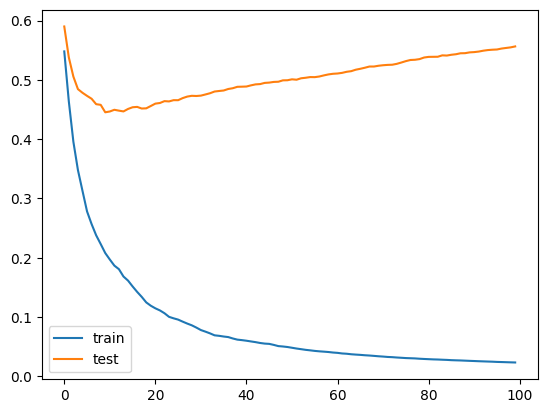

In [66]:
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [75]:
regr = RidgeClassifier()
regr.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

TypeError: RidgeClassifier.fit() got an unexpected keyword argument 'eval_metric'

In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=1)
model = RidgeClassifier()
evalset = [(X_train2, y_train2), (X_val,y_val)]
model.fit(X_train2, y_train2)

RidgeClassifier()

In [ ]:
y_hat = model.predict(X_test)
score = accuracy_score(y_test, yhat)

In [ ]:
yhat2 = []
for k in yhat:
    if k > 0.5:
        yhat2.append(1)
    else:
        yhat2.append(0)

In [ ]:
score = accuracy_score(y_test, yhat2)

In [ ]:
y_hat

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat2)
print('Accuracy: %.3f' % score)

Accuracy: 0.765


In [ ]:
# retrieve performance metrics
results = model.evals_result()

AttributeError: 'RidgeClassifier' object has no attribute 'evals_result'

In [ ]:
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
from sklearn.model_selection import validation_curve

In [ ]:
with open('data_FAA/data.pkl', 'wb') as f:
    joblib.dump([X_train, y_train, X_test, y_test], f)

In [ ]:
validation_curve()

In [ ]:
PARAMETERS = {'normalize' : [True, False],
              'positive': [True, False],}

# HalvingGridSearchCV
grid_search_xgb = HalvingGridSearchCV(estimator=RidgeClassifier(),param_grid=PARAMETERS,verbose = 1,
                                                           cv = 10,scoring='accuracy',max_resources=1000,random_state = 0,
                                                           resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

xgbr_best = grid_search_xgb.best_estimator_
print("Elastic Net")
print('xgbr_best Best Score',grid_search_xgb.best_score_)
print('xgbr_best Best Parmas',grid_search_xgb.best_params_)
print('xgbr_best Accuracy',cross_val_score(xgbr_best,X_train.values, y_train.values.ravel(), cv=10).mean())
# print('xgbr feature importances',grid_search_xgb.feature_importances_)

In [ ]:
perm = PermutationImportance(grid_search_xgb, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
pred = grid_search_xgb.predict(X_test)
print(classification_report(y_test, pred, target_names=["0","1"]))
plot_roc_curve(grid_search_xgb, X_test, y_test)
#Comentário

In [ ]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/test.csv")
data2['Transported'] =-1
dataT = pd.concat([data1,data2],axis = 0,ignore_index=True)

df_T,target = preprocess(dataT,preTrain = False)
X_testT = df_T[df_T['Transported'] ==-1]
X_testT = X_testT.drop(['Transported'],axis = 1)

pred = grid_search_xgb.predict(X_testT)
pred = pred.astype(bool)

result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission.csv', index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (XGBoosting)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = xgb.XGBClassifier()
plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=axes[:, 0],
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="accuracy",
)

title = r"Learning Curves (Elastic Net)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = RidgeClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()